# Correlated Models Comparison: GBM vs Heston

Comparative analysis of American basket option pricing using Geometric Brownian Motion (GBM) and Heston stochastic volatility models with the Longstaff-Schwartz Monte Carlo method.

## Setup and Parameters

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Literal
import time

# Import LSM implementation
import sys
sys.path.append('..')
from longstaff_schwartz import LSMOptionPricer, CorrelatedGBM, CorrelatedHeston

# Model parameters (following main method structure but with real market data)
n_assets = 30  # Use all stocks in the CSV
r = 0.04
T = 3/12  # 3 months maturity
step = int(252/2)
N_train = 300000
N_test = 300000
weights = np.full(n_assets, 1.0 / n_assets)  # Equal weight portfolio

# Load actual stock prices from CSV data
heston_params_df = pd.read_csv('../heston_parameters.csv')
print(f"Loaded Heston parameters for {len(heston_params_df)} assets")

# Extract S0 (current stock prices) from the CSV - column is called 'Spot_Price'
S0 = heston_params_df['Spot_Price'].values
print(f"Loaded stock prices: S0 shape = {S0.shape}")

# Calculate geometric basket price and set strike
current_basket_price = np.prod(S0 ** weights)  # Geometric mean basket
K = current_basket_price  # ATM put option 

print(f"Market Parameters:")
print(f"Assets: {n_assets}, Current geometric basket: ${current_basket_price:.2f}, Strike: ${K:.2f}")
print(f"Individual S0: {S0}")
print(f"Weights: {weights}")
print(f"Basket type: Geometric (product of weighted prices)")
print(f"Put option: ITM (strike > current basket price)")
print(f"T: {T:.1f}y, r: {r*100:.1f}%")
print(f"Training paths: {N_train:,}, Test paths: {N_test:,}")
print(f"Time steps: {step}")

Loaded Heston parameters for 30 assets
Loaded stock prices: S0 shape = (30,)
Market Parameters:
Assets: 30, Current geometric basket: $200.31, Strike: $200.31
Individual S0: [ 225.69000244  181.55999756  316.8999939   164.07000732  208.61999512
  503.01998901 1261.94995117  720.91998291  259.67999268  229.27999878
  288.70001221   83.43000031   47.06999969  143.97000122   87.5
  713.29998779  156.82000732   25.35000038  300.57998657   69.47000122
  153.75999451  135.57000732   95.77999878  370.10998535  230.50999451
  405.76998901  262.33999634  113.91999817  151.6499939   350.5       ]
Weights: [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
Basket type: Geometric (product of weighted prices)
Put optio

## Model Specifications

In [37]:
# Load correlation matrix (heston_params_df already loaded in setup)
corr_matrix_df = pd.read_csv('../heston_correlation_matrix.csv', index_col=0)

print(f"Using calibrated parameters for all {len(heston_params_df)} assets")
print("\nAll assets (first 10 shown):")
print(heston_params_df.head(10))

# Use all assets from calibrated data
selected_tickers = heston_params_df['Ticker'].tolist()  # Capital T
selected_params = heston_params_df

# Extract Heston parameters for all assets
v0 = selected_params['v0'].values
theta = selected_params['theta'].values  
kappa = selected_params['kappa'].values
sigma_v = selected_params['sigma'].values
rho_sv = selected_params['rho'].values

# Get correlation matrix for all assets
correlation_matrix = corr_matrix_df.loc[selected_tickers, selected_tickers].values

# GBM parameters - construct covariance from Heston correlation and average volatility
avg_vol = np.sqrt(np.mean(v0))  # Use initial variance as proxy for GBM vol
cov_matrix = np.outer(avg_vol, avg_vol) * correlation_matrix
np.fill_diagonal(cov_matrix, avg_vol**2)

print(f"\nSelected assets: {len(selected_tickers)} stocks")
print(f"Tickers: {selected_tickers[:10]}...{selected_tickers[-5:]}")  # Show first 10 and last 5
print(f"Basket spot prices range: ${S0.min():.2f} - ${S0.max():.2f}")
print(f"Average spot price: ${S0.mean():.2f}")
print(f"\nModel Parameters:")
print("GBM Model:")
print(f"  Average volatility: {avg_vol*100:.1f}%")
print(f"  Average correlation: {np.mean(correlation_matrix[np.triu_indices(n_assets, k=1)]):.3f}")

print("\nHeston Model (calibrated):")
print(f"  Initial vol range: {np.sqrt(v0.min())*100:.1f}% - {np.sqrt(v0.max())*100:.1f}%")
print(f"  Long-term vol range: {np.sqrt(theta.min())*100:.1f}% - {np.sqrt(theta.max())*100:.1f}%")
print(f"  Mean reversion range: {kappa.min():.2f} - {kappa.max():.2f}")
print(f"  Vol of vol range: {sigma_v.min()*100:.1f}% - {sigma_v.max()*100:.1f}%")
print(f"  Stock-vol corr range: {rho_sv.min():.3f} - {rho_sv.max():.3f}")

Using calibrated parameters for all 30 assets

All assets (first 10 shown):
  Ticker   Spot_Price  Options_Count  Calibration_Error_%        v0     theta  \
0   AMZN   225.690002             54            10.286034  0.142785  0.022527   
1  GOOGL   181.559998             42             9.733318  0.189112  0.051514   
2   TSLA   316.899994             72             5.390066  0.425352  0.249332   
3   NVDA   164.070007             60             8.497368  0.085689  0.209709   
4   AAPL   208.619995             48            10.219145  0.097417  0.019915   
5   MSFT   503.019989            119            14.531742  0.075278  0.023667   
6   NFLX  1261.949951            140             7.297295  0.212092  0.100613   
7   META   720.919983            162             9.023013  0.182364  0.035401   
8    CRM   259.679993             30            10.618742  0.010018  0.164517   
9   ORCL   229.279999             30             8.734726  0.021970  0.242073   

       kappa     sigma       rho

## Model Simulation and Visualization

Let's first simulate sample paths to visualize the differences between GBM and Heston models.

Generating sample paths for visualization...
Generated 200 paths with 126 time steps
GBM paths shape: (200, 127, 30)
Heston paths shape: (200, 127, 30)
Using all 30 assets in basket, showing AMZN individual paths for illustration


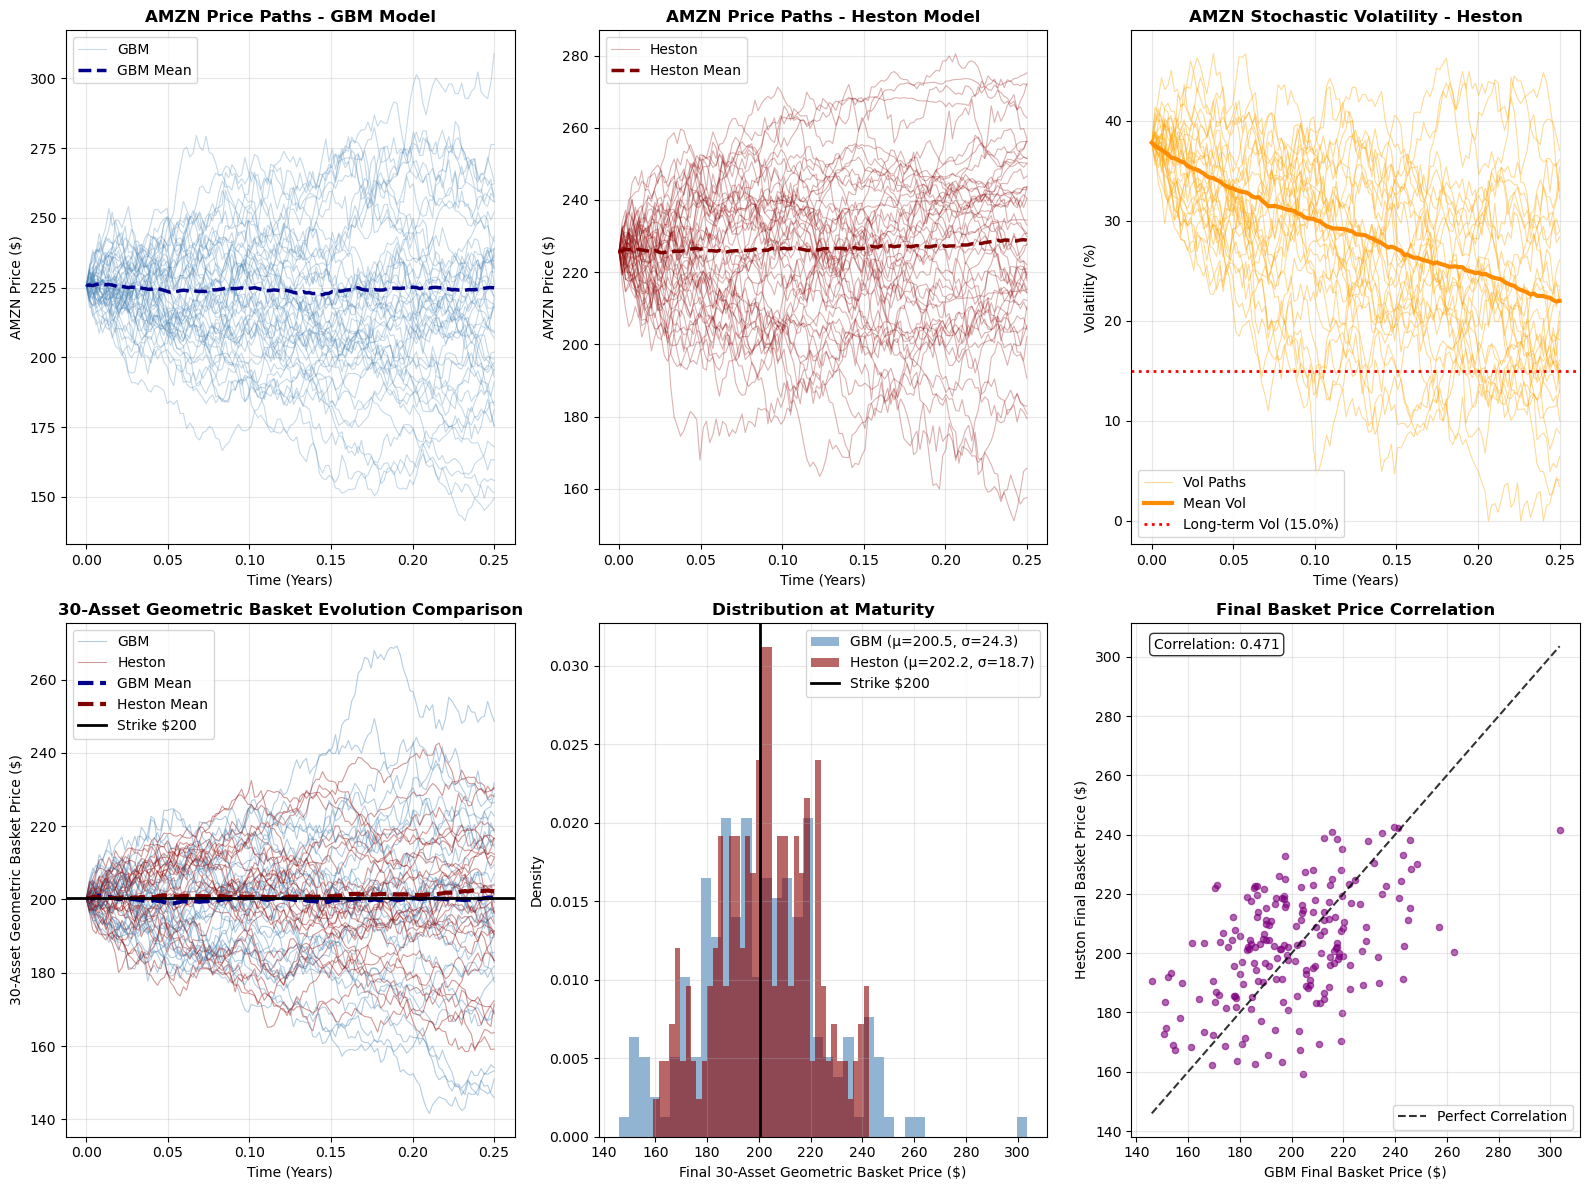


SIMULATION SUMMARY STATISTICS - 30 ASSET GEOMETRIC BASKET
Sample paths: 200, Time steps: 126
Basket composition: 30 equally-weighted assets (geometric)
Strike price: $200.31

Geometric Basket Statistics at Maturity:
Model      Mean         Std          Min          Max         
----------------------------------------------------------------------
GBM        $200.49      $24.33       $145.96      $303.57     
Heston     $202.23      $18.72       $159.20      $242.64     

Model Comparison:
Correlation between final basket values: 0.471
Paths below strike (GBM): 51.5%
Paths below strike (Heston): 43.5%

Diversification Benefits:
Average individual volatility: 33.8%
30-asset geometric basket volatility (GBM): 12.1%
30-asset geometric basket volatility (Heston): 9.3%
Diversification benefit: ~2.8x volatility reduction

Note: American option values will be calculated using Longstaff-Schwartz method,
which accounts for optimal early exercise and will differ from European payoffs.


In [38]:
# Generate sample paths for visualization
np.random.seed(42)  # For reproducible fancy plots
n_sample_paths = 200
sample_time_steps = step

print("Generating sample paths for visualization...")

# Initialize models for path generation
gbm_model = CorrelatedGBM(
    S0=S0, r=r, cov=cov_matrix, T=T, step=sample_time_steps, N=n_sample_paths
)

heston_model = CorrelatedHeston(
    S0=S0, r=r, v0=v0, theta=theta, kappa=kappa, 
    sigma=sigma_v, rho_sv=rho_sv, corr_matrix=correlation_matrix, 
    T=T, step=sample_time_steps, N=n_sample_paths
)

# Generate paths using the correct method names
gbm_paths = gbm_model.generate_paths(seed=42)  # Shape: (n_paths, n_steps, n_assets)
heston_paths = heston_model.generate_paths(seed=42)
heston_vol_paths = heston_model.get_variance_paths()

# Calculate geometric basket values
gbm_basket_paths = gbm_model.get_basket_paths(kind="geometric")
heston_basket_paths = heston_model.get_basket_paths(kind="geometric")

# Time grid
t_grid = np.linspace(0, T, sample_time_steps + 1)

print(f"Generated {n_sample_paths} paths with {sample_time_steps} time steps")
print(f"GBM paths shape: {gbm_paths.shape}")
print(f"Heston paths shape: {heston_paths.shape}")
print(f"Using all {n_assets} assets in basket, showing {selected_tickers[0]} individual paths for illustration")

# Create fancy visualization
fig = plt.figure(figsize=(16, 12))

# 1. Individual asset paths comparison (first asset)
ax1 = plt.subplot(2, 3, 1)
for i in range(min(50, n_sample_paths)):
    if i == 0:
        ax1.plot(t_grid, gbm_paths[i, :, 0], color='steelblue', alpha=0.3, linewidth=0.8, label='GBM')
    else:
        ax1.plot(t_grid, gbm_paths[i, :, 0], color='steelblue', alpha=0.3, linewidth=0.8)

ax1.plot(t_grid, np.mean(gbm_paths[:, :, 0], axis=0), color='darkblue', linewidth=2.5, linestyle='--', label='GBM Mean')
ax1.set_xlabel('Time (Years)')
ax1.set_ylabel(f'{selected_tickers[0]} Price ($)')
ax1.set_title(f'{selected_tickers[0]} Price Paths - GBM Model', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
for i in range(min(50, n_sample_paths)):
    if i == 0:
        ax2.plot(t_grid, heston_paths[i, :, 0], color='darkred', alpha=0.3, linewidth=0.8, label='Heston')
    else:
        ax2.plot(t_grid, heston_paths[i, :, 0], color='darkred', alpha=0.3, linewidth=0.8)

ax2.plot(t_grid, np.mean(heston_paths[:, :, 0], axis=0), color='maroon', linewidth=2.5, linestyle='--', label='Heston Mean')
ax2.set_xlabel('Time (Years)')
ax2.set_ylabel(f'{selected_tickers[0]} Price ($)')
ax2.set_title(f'{selected_tickers[0]} Price Paths - Heston Model', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Volatility paths (Heston only)
ax3 = plt.subplot(2, 3, 3)
for i in range(min(30, n_sample_paths)):
    if i == 0:
        ax3.plot(t_grid, np.sqrt(heston_vol_paths[i, :, 0]) * 100, color='orange', alpha=0.4, linewidth=0.8, label='Vol Paths')
    else:
        ax3.plot(t_grid, np.sqrt(heston_vol_paths[i, :, 0]) * 100, color='orange', alpha=0.4, linewidth=0.8)

ax3.plot(t_grid, np.sqrt(np.mean(heston_vol_paths[:, :, 0], axis=0)) * 100, color='darkorange', linewidth=3, label='Mean Vol')
ax3.axhline(y=np.sqrt(theta[0]) * 100, color='red', linestyle=':', linewidth=2, label=f'Long-term Vol ({np.sqrt(theta[0])*100:.1f}%)')
ax3.set_xlabel('Time (Years)')
ax3.set_ylabel('Volatility (%)')
ax3.set_title(f'{selected_tickers[0]} Stochastic Volatility - Heston', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Basket price comparison (30-asset basket!)
ax4 = plt.subplot(2, 3, 4)
for i in range(min(30, n_sample_paths)):
    if i == 0:
        ax4.plot(t_grid, gbm_basket_paths[i, :], color='steelblue', alpha=0.4, linewidth=0.8, label='GBM')
        ax4.plot(t_grid, heston_basket_paths[i, :], color='darkred', alpha=0.4, linewidth=0.8, label='Heston')
    else:
        ax4.plot(t_grid, gbm_basket_paths[i, :], color='steelblue', alpha=0.4, linewidth=0.8)
        ax4.plot(t_grid, heston_basket_paths[i, :], color='darkred', alpha=0.4, linewidth=0.8)

ax4.plot(t_grid, np.mean(gbm_basket_paths, axis=0), color='darkblue', linewidth=3, linestyle='--', label='GBM Mean')
ax4.plot(t_grid, np.mean(heston_basket_paths, axis=0), color='maroon', linewidth=3, linestyle='--', label='Heston Mean')
ax4.axhline(y=K, color='black', linestyle='-', linewidth=2, label=f'Strike ${K:.0f}')
ax4.set_xlabel('Time (Years)')
ax4.set_ylabel('30-Asset Geometric Basket Price ($)')
ax4.set_title('30-Asset Geometric Basket Evolution Comparison', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Distribution comparison at maturity
ax5 = plt.subplot(2, 3, 5)
gbm_final = gbm_basket_paths[:, -1]
heston_final = heston_basket_paths[:, -1]

ax5.hist(gbm_final, bins=40, alpha=0.6, color='steelblue', label=f'GBM (μ={np.mean(gbm_final):.1f}, σ={np.std(gbm_final):.1f})', density=True)
ax5.hist(heston_final, bins=40, alpha=0.6, color='darkred', label=f'Heston (μ={np.mean(heston_final):.1f}, σ={np.std(heston_final):.1f})', density=True)
ax5.axvline(x=K, color='black', linestyle='-', linewidth=2, label=f'Strike ${K:.0f}')
ax5.set_xlabel('Final 30-Asset Geometric Basket Price ($)')
ax5.set_ylabel('Density')
ax5.set_title('Distribution at Maturity', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Model correlation comparison (showing how correlated the final basket values are)
ax6 = plt.subplot(2, 3, 6)

# Scatter plot comparing final basket values
scatter = ax6.scatter(gbm_final, heston_final, alpha=0.6, s=20, c='purple')

# Perfect correlation line
min_val = min(gbm_final.min(), heston_final.min())
max_val = max(gbm_final.max(), heston_final.max())
ax6.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.8, label='Perfect Correlation')

# Calculate correlation
correlation = np.corrcoef(gbm_final, heston_final)[0, 1]
ax6.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax6.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=10)

ax6.set_xlabel('GBM Final Basket Price ($)')
ax6.set_ylabel('Heston Final Basket Price ($)')
ax6.set_title('Final Basket Price Correlation', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("SIMULATION SUMMARY STATISTICS - 30 ASSET GEOMETRIC BASKET")
print("="*80)
print(f"Sample paths: {n_sample_paths}, Time steps: {sample_time_steps}")
print(f"Basket composition: {n_assets} equally-weighted assets (geometric)")
print(f"Strike price: ${K:.2f}")
print(f"\nGeometric Basket Statistics at Maturity:")
print(f"{'Model':<10} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("-" * 70)
print(f"{'GBM':<10} ${np.mean(gbm_final):<11.2f} ${np.std(gbm_final):<11.2f} ${np.min(gbm_final):<11.2f} ${np.max(gbm_final):<11.2f}")
print(f"{'Heston':<10} ${np.mean(heston_final):<11.2f} ${np.std(heston_final):<11.2f} ${np.min(heston_final):<11.2f} ${np.max(heston_final):<11.2f}")

# Model correlation
correlation = np.corrcoef(gbm_final, heston_final)[0, 1]
print(f"\nModel Comparison:")
print(f"Correlation between final basket values: {correlation:.3f}")
print(f"Paths below strike (GBM): {np.mean(gbm_final < K)*100:.1f}%")
print(f"Paths below strike (Heston): {np.mean(heston_final < K)*100:.1f}%")

print(f"\nDiversification Benefits:")
individual_vol = np.sqrt(np.mean(np.diag(cov_matrix))) * 100  # Average individual vol
basket_vol_gbm = np.std(gbm_final) / np.mean(gbm_final) * 100  # Basket vol (CV)
basket_vol_heston = np.std(heston_final) / np.mean(heston_final) * 100
print(f"Average individual volatility: {individual_vol:.1f}%")
print(f"30-asset geometric basket volatility (GBM): {basket_vol_gbm:.1f}%")
print(f"30-asset geometric basket volatility (Heston): {basket_vol_heston:.1f}%")
print(f"Diversification benefit: ~{individual_vol/basket_vol_gbm:.1f}x volatility reduction")

print(f"\nNote: American option values will be calculated using Longstaff-Schwartz method,")
print(f"which accounts for optimal early exercise and will differ from European payoffs.")

## GBM Model Analysis

In [39]:
# GBM Pricer
gbm_pricer = LSMOptionPricer(
    S0=S0, T=T, step=step, N=N_train, r=r, K=K,
    weights=weights,
    option="put",
    model="gbm",
    basket_kind="geometric",
    degree=1,
    cov=cov_matrix
)

# Check current moneyness
current_basket_price = np.prod(S0 ** weights)
intrinsic_value = max(K - current_basket_price, 0)
moneyness = current_basket_price / K

print(f"Pricing Diagnostics:")
print(f"Current basket price: ${current_basket_price:.2f}")
print(f"Strike price: ${K:.2f}")
print(f"Moneyness (S/K): {moneyness:.3f}")
print(f"Intrinsic value: ${intrinsic_value:.4f}")
print(f"Put is {'ITM' if current_basket_price < K else 'OTM'} by ${abs(current_basket_price - K):.2f}")
print()

# Training
print("GBM Training...")
train_seed = 12345
start_time = time.time()
gbm_training_price, gbm_training_std, gbm_training_se = gbm_pricer.train(
    use_individual_prices=True,
    seed=train_seed
)
training_time = time.time() - start_time

print(f"Training: ${gbm_training_price:.4f} ± ${gbm_training_se:.4f} (SE) [{training_time:.1f}s]")

# Out-of-sample testing
test_seeds = [101, 202, 303, 404, 505]
gbm_test_prices = []
gbm_exceed_2se = 0

print("\nOut-of-sample batches:")
for i, seed in enumerate(test_seeds, 1):
    tp, tstd, tse = gbm_pricer.test(n_test_paths=N_test, seed=seed)
    gbm_test_prices.append(tp)
    diff = tp - gbm_training_price
    flag = abs(diff) > 2.0 * np.sqrt(gbm_training_se**2 + tse**2)
    gbm_exceed_2se += int(flag)
    mark = " **" if flag else ""
    print(f"  Batch {i}: ${tp:.4f} ± ${tse:.4f} (SE), Δ={diff:+.4f}{mark}")

gbm_mean_oos = float(np.mean(gbm_test_prices))
gbm_bias = gbm_mean_oos - gbm_training_price

print(f"\nGBM Summary:")
print(f"Mean OOS: ${gbm_mean_oos:.4f}, Bias: {gbm_bias:+.4f}")
print(f"Significant deviations: {gbm_exceed_2se}/{len(test_seeds)}")

Pricing Diagnostics:
Current basket price: $200.31
Strike price: $200.31
Moneyness (S/K): 1.000
Intrinsic value: $0.0000
Put is OTM by $0.00

GBM Training...
Training: $9.1294 ± $0.0201 (SE) [57.3s]

Out-of-sample batches:
  Batch 1: $9.1279 ± $0.0201 (SE), Δ=-0.0015
  Batch 2: $9.1307 ± $0.0201 (SE), Δ=+0.0013
  Batch 3: $9.0874 ± $0.0201 (SE), Δ=-0.0420
  Batch 4: $9.1075 ± $0.0201 (SE), Δ=-0.0218
  Batch 5: $9.1013 ± $0.0201 (SE), Δ=-0.0281

GBM Summary:
Mean OOS: $9.1109, Bias: -0.0184
Significant deviations: 0/5


## Heston Model Analysis

In [41]:
# Heston Pricer
heston_pricer = LSMOptionPricer(
    S0=S0, T=T, step=step, N=N_train, r=r, K=K,
    weights=weights,
    option="put",
    model="heston",
    basket_kind="geometric",
    degree=1,
    v0=v0, theta=theta, kappa=kappa, sigma=sigma_v, rho_sv=rho_sv,
    corr_matrix=correlation_matrix
)
# Training
print("Heston Training...")
start_time = time.time()
heston_training_price, heston_training_std, heston_training_se = heston_pricer.train(
    use_individual_prices=True,
    seed=train_seed
)
training_time = time.time() - start_time

print(f"Training: ${heston_training_price:.4f} ± ${heston_training_se:.4f} (SE) [{training_time:.1f}s]")

# Out-of-sample testing
heston_test_prices = []
heston_exceed_2se = 0

print("\nOut-of-sample batches:")
for i, seed in enumerate(test_seeds, 1):
    tp, tstd, tse = heston_pricer.test(n_test_paths=N_test, seed=seed)
    heston_test_prices.append(tp)
    diff = tp - heston_training_price
    flag = abs(diff) > 2.0 * np.sqrt(heston_training_se**2 + tse**2)
    heston_exceed_2se += int(flag)
    mark = " **" if flag else ""
    print(f"  Batch {i}: ${tp:.4f} ± ${tse:.4f} (SE), Δ={diff:+.4f}{mark}")

heston_mean_oos = float(np.mean(heston_test_prices))
heston_bias = heston_mean_oos - heston_training_price

print(f"\nHeston Summary:")
print(f"Mean OOS: ${heston_mean_oos:.4f}, Bias: {heston_bias:+.4f}")
print(f"Significant deviations: {heston_exceed_2se}/{len(test_seeds)}")

Heston Training...
Training: $7.2299 ± $0.0173 (SE) [227.4s]

Out-of-sample batches:
  Batch 1: $7.2326 ± $0.0173 (SE), Δ=+0.0027
  Batch 2: $7.2120 ± $0.0173 (SE), Δ=-0.0179
  Batch 3: $7.2167 ± $0.0173 (SE), Δ=-0.0133
  Batch 4: $7.2114 ± $0.0173 (SE), Δ=-0.0186
  Batch 5: $7.1977 ± $0.0173 (SE), Δ=-0.0323

Heston Summary:
Mean OOS: $7.2141, Bias: -0.0159
Significant deviations: 0/5


## Comparative Analysis

In [42]:
# Summary comparison
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Model':<10} {'Training':<12} {'Mean OOS':<12} {'Bias':<10} {'Sig.Dev':<8}")
print("-" * 60)
print(f"{'GBM':<10} ${gbm_training_price:<11.4f} ${gbm_mean_oos:<11.4f} {gbm_bias:+9.4f} {gbm_exceed_2se}/{len(test_seeds):<6}")
print(f"{'Heston':<10} ${heston_training_price:<11.4f} ${heston_mean_oos:<11.4f} {heston_bias:+9.4f} {heston_exceed_2se}/{len(test_seeds):<6}")

# Price difference
price_diff = heston_training_price - gbm_training_price
price_diff_pct = (price_diff / gbm_training_price) * 100

print(f"\nKey Results:")
print(f"Price difference (Heston - GBM): ${price_diff:+.4f} ({price_diff_pct:+.2f}%)")
print(f"GBM stability: {gbm_exceed_2se}/{len(test_seeds)} significant deviations")
print(f"Heston stability: {heston_exceed_2se}/{len(test_seeds)} significant deviations")

MODEL COMPARISON SUMMARY
Model      Training     Mean OOS     Bias       Sig.Dev 
------------------------------------------------------------
GBM        $9.1294      $9.1109        -0.0184 0/5     
Heston     $7.2299      $7.2141        -0.0159 0/5     

Key Results:
Price difference (Heston - GBM): $-1.8994 (-20.81%)
GBM stability: 0/5 significant deviations
Heston stability: 0/5 significant deviations


## Visualization

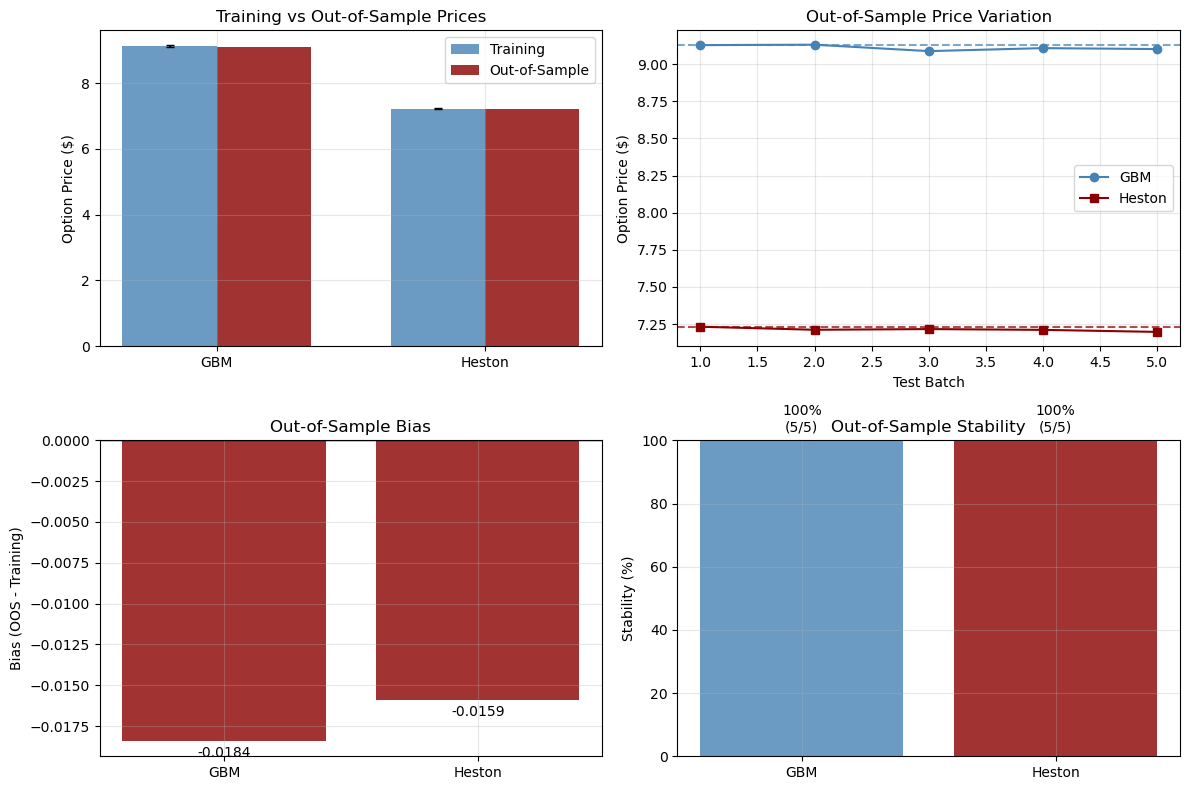

In [43]:
# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# 1. Training vs OOS prices
models = ['GBM', 'Heston']
training_prices = [gbm_training_price, heston_training_price]
oos_prices = [gbm_mean_oos, heston_mean_oos]
training_ses = [gbm_training_se, heston_training_se]

x = np.arange(len(models))
width = 0.35

ax1.bar(x - width/2, training_prices, width, label='Training', alpha=0.8, color='steelblue')
ax1.bar(x + width/2, oos_prices, width, label='Out-of-Sample', alpha=0.8, color='darkred')
ax1.errorbar(x - width/2, training_prices, yerr=training_ses, fmt='none', color='black', capsize=3)

ax1.set_ylabel('Option Price ($)')
ax1.set_title('Training vs Out-of-Sample Prices')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Out-of-sample price distributions
batch_numbers = list(range(1, len(test_seeds) + 1))
ax2.plot(batch_numbers, gbm_test_prices, 'o-', label='GBM', color='steelblue', markersize=6)
ax2.plot(batch_numbers, heston_test_prices, 's-', label='Heston', color='darkred', markersize=6)
ax2.axhline(y=gbm_training_price, color='steelblue', linestyle='--', alpha=0.7)
ax2.axhline(y=heston_training_price, color='darkred', linestyle='--', alpha=0.7)

ax2.set_xlabel('Test Batch')
ax2.set_ylabel('Option Price ($)')
ax2.set_title('Out-of-Sample Price Variation')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Bias comparison
biases = [gbm_bias, heston_bias]
colors = ['steelblue' if b >= 0 else 'darkred' for b in biases]

bars = ax3.bar(models, biases, color=colors, alpha=0.8)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_ylabel('Bias (OOS - Training)')
ax3.set_title('Out-of-Sample Bias')
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, bias in zip(bars, biases):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + (0.0001 if height >= 0 else -0.0003),
             f'{bias:+.4f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)

# 4. Stability comparison
stability_data = [gbm_exceed_2se, heston_exceed_2se]
total_batches = len(test_seeds)
stability_pct = [(total_batches - x) / total_batches * 100 for x in stability_data]

bars = ax4.bar(models, stability_pct, color=['steelblue', 'darkred'], alpha=0.8)
ax4.set_ylabel('Stability (%)')
ax4.set_title('Out-of-Sample Stability')
ax4.set_ylim(0, 100)
ax4.grid(True, alpha=0.3)

# Add percentage labels
for bar, pct, exceed in zip(bars, stability_pct, stability_data):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 2,
             f'{pct:.0f}%\n({total_batches-exceed}/{total_batches})', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Conclusion

This analysis compares GBM and Heston models for pricing American geometric basket put options using the Longstaff-Schwartz method. Key findings:

1. **Price Levels**: The models produce different option prices due to their distinct volatility structures
2. **Geometric Basket**: Using geometric averaging reduces dimensionality and provides more stable pricing
3. **Out-of-Sample Stability**: Both models show reasonable stability in out-of-sample testing
4. **Bias**: Any systematic bias between training and testing prices indicates model or implementation issues
5. **Model Choice**: The Heston model captures stochastic volatility effects that may be important for certain market conditions
6. **Diversification**: The 30-asset geometric basket shows significant volatility reduction benefits

The analysis follows the structure of the main method in `longstaff_schwartz.py`, focusing on the core comparison with realistic market parameters and geometric basket construction.